# Презентация


###1.   Как работи модела?
###2.   Какво предсказва модела?
###3.   Как може да изглежда статия?

###1. Как работи моделът?

### Данни:
- от ИАОС и 5те станции за измерване качеството на въздуха
- получих данните и за петте станции, но съм правил прогнози само за станцията в Дружба
- данните са в часови интервали и така ги използвам в модела. Прогнозите след това ги усреднявам за ден, защото исках да се придържам към формата на прогнозата на НИМХ на air.sofia.bg
- данните за от 01.01.2006 до 30.05.2020, но мога по ЗДОИ да поискам и тези до днешна дата
- данните от станциите съдържат параметрите: 
 - NO2, ug/m3
 - SO2, ug/m3
 - PM10, ug/m3
 - AirTemp, Celsius
 - GSR, W/m2
 - Press, mbar
 - UMR, %
 - WD, degree
 - WS, m/s
 - O3, ug/m3

 - от тях обаче не използвах NO2, UMR и pressure, защото правят прогнозите по-лоши. Опитах се да ги заместя със стойности от други станции или усреднени стойности за София, но това проработи само за pressure, докато NO2 и UMR си останаха проблемни

 - за една станция, Хиподрума, имаше и ФПЧ2.5 стойности, но не помагат

  - тествах дали и други данни ще помогнат - валежи от Борисовата градина,  данни за валежи от stringmeteo.bg както и точка на оросяване пак от там. Въпреки началните резултати валежите не помогат, но стойности за точка на оросяване помагат
  - създадох и мои величини - "continous time stamp" и "week day stamp". И двата подобряват модела, особено първият. Освен това обърнах WD, degree и WS, m/s във вектори, за да няма конфликти при прескачане от 359 на 0 градуса
  - може би други стойности също да помогнат - прах от сахара, производство на ел. енергия в близки ТЕЦове, сателитни спектри от снимки на София...
   - поисках данни за трафика за София, които прочетох че се събират, но заместник кмета не пожела да ми ги даде. Не знам дали ги поддържат наситина

	 

---

### Архитектура:
- статистически модел от вида на машинно обучение (ML)
- по-точно, използва архитектурата на Long Short Term Memory за корелация на събития в кратки и дълги периоди
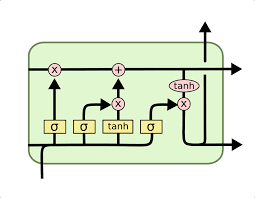
- използва се от 5-6 години и е нещо като стандарт за времеви криви, особено ако съдържат пуло-периодични събития
- не съм писал уравненията сам, а използвам готовите библиотеки на google tensorflow и keras
- не съм направил нещо находчиво или изобретателно, моделът е общо взето "of the shelve", но мисля че върши работа


###2. Какво предсказва моделът?

In [ ]:
from IPython.display import Image
from google.colab import drive
drive.mount('/content/drive')

import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
import pandas as pd
import scipy

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import SGD, Adam
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *

%load_ext google.colab.data_table

logpath_ms = './bestmodel_20210219_for_presentation.h5'

Mounted at /content/drive


Зареждане на данните на ИАОС за Дружба от файл и обработване:

In [ ]:
df0 = pd.read_excel('/content/drive/MyDrive/sync computer files/personal_code_data_projects/vazduh_sofia/data_IOAS_air_sofia_alltime/София - Дружба 2006 - 30.05.2020 с метеорологични параметри.xls', skiprows=0, header=1, sheet_name=None)
# concatenate all sheets of the excel file
df = pd.concat(df0[frame] for frame in df0.keys())
df.reset_index(drop=True, inplace=True)
df.Час.replace(to_replace='24:00', value='00:00', inplace=True)
df['datetime'] = df['Дата'] + ' ' + df['Час']
df['datetime'] = pd.to_datetime(df['datetime'], format='%d.%m.%Y %H:%M')

# if the hour is 00:00 shift to the next day. This is necessary, because I change the format above from 24:00 to 00:00
df.datetime[df.Час == '00:00'] = df.datetime + pd.DateOffset(1)
df.datetime = df.datetime - pd.DateOffset(hours=1)

df['hour_stamp'] = df.index
df['weekday_ind'] = df.datetime.dt.dayofweek
df.set_index(['datetime'], inplace=True)

# interpolate missing values here and there
df.interpolate(method='linear', axis=0, inplace=True)

# turn also the wind velocity and direction to vectors
# Convert to radians.
wd_rad = df['WD, degree']*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = df['WS, m/s']*np.cos(wd_rad)
df['Wy'] = df['WS, m/s']*np.sin(wd_rad)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


Така изглеждат данните заредени в таблица:

In [ ]:
df

,Дата,Час,"NO2, ug/m3","SO2, ug/m3","PM10, ug/m3","AirTemp, Celsius","GSR, W/m2","Press, mbar","UMR, %","WD, degree","WS, m/s","O3, ug/m3",hour_stamp,weekday_ind,Wx,Wy
datetime,,,,,,,,,,,,,,,,
2006-01-01 00:00:00,01.01.2006,01:00,121.82,51.43,198.36,1.9,0.6,957.0,70.6,227.44,1.06,8.74,0,6,-0.716944,-0.780764
2006-01-01 01:00:00,01.01.2006,02:00,120.78,25.97,262.14,1.7,0.0,956.8,74.6,223.23,0.94,4.44,1,6,-0.684893,-0.643833
2006-01-01 02:00:00,01.01.2006,03:00,112.51,15.54,158.56,1.8,0.6,956.8,74.8,239.23,0.74,2.58,2,6,-0.378579,-0.635829
2006-01-01 03:00:00,01.01.2006,04:00,100.63,13.93,136.10,1.5,0.4,956.7,77.5,113.68,1.03,4.98,3,6,-0.413677,0.943277
2006-01-01 04:00:00,01.01.2006,05:00,66.11,16.12,118.27,1.0,0.0,956.2,78.9,95.83,1.06,16.58,4,6,-0.107672,1.054517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-30 19:00:00,30.05.2020,20:00,22.01,6.49,19.34,13.7,2.6,939.2,15.4,346.79,1.83,56.04,126331,5,1.781576,-0.418193
2020-05-30 20:00:00,30.05.2020,21:00,13.52,6.22,14.23,12.5,0.0,939.0,37.4,283.28,1.69,61.04,126332,5,0.388210,-1.644808
2020-05-30 21:00:00,30.05.2020,22:00,15.68,6.38,9.79,11.7,0.0,938.7,81.5,280.17,1.80,56.34,126333,5,0.317825,-1.771719


Зареждане на данните от Копитото, за да извлечем от тях налягането:

In [ ]:
dfp0 = pd.read_excel('/content/drive/MyDrive/sync computer files/personal_code_data_projects/vazduh_sofia/data_IOAS_air_sofia_alltime/София-Копитото 2007-30.05.2020 с метеорологични параметри.xls', skiprows=0, header=1, sheet_name=None)
# concatenate all sheets of the excel file
dfp = pd.concat(dfp0[frame] for frame in dfp0.keys())
dfp.reset_index(drop=True, inplace=True)
dfp.Час.replace(to_replace='24:00', value='00:00', inplace=True)
dfp['datetime'] = dfp['Дата'] + ' ' + dfp['Час']
dfp['datetime'] = pd.to_datetime(dfp['datetime'], format='%d.%m.%Y %H:%M')

# if the hour is 00:00 shift to the next day. This is necessary, because I change the format above from 24:00 to 00:00
dfp.datetime[dfp.Час == '00:00'] = dfp.datetime + pd.DateOffset(1)
dfp.datetime = dfp.datetime - pd.DateOffset(hours=1)

# interpolate missing values here and there
dfp.interpolate(method='linear', axis=0, inplace=True)

# substitute the values for pressure, humidity and NO2 in df with the ones from Pavlovo in dfp
df[['Press, mbar','UMR, %','NO2, ug/m3']] = dfp[['Press, mbar','UMR, %','NO2, ug/m3']]
# df['PM2.5, ug/m3'] = dfp['PM2.5, ug/m3']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
# clean the df from sections were data is obviously having bad values/erronous measurements
df['WS, m/s'][60500:65500] = np.nan
df['WS, m/s'][42000:47000] = np.nan
df['WS, m/s'][112000:118000] = np.nan

df['UMR, %'][42000:50000] = np.nan

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from 

Зареждане на данни от stringmeteo.bg, за да използваме стойности за точка на оросяване:

In [ ]:
df3 = pd.read_csv('/content/drive/MyDrive/sync computer files/personal_code_data_projects/vazduh_sofia/danni_valeji/PrecTdew_03-20_processed.csv', header=0, sep=',', dtype={'София': 'float', 'срок[UTC]': 'str', 'година': 'str', 'месец':'str', 'ден':'str', 'в.3h': 'float', 'в.6h':'float', 'в.12h':'float'})
df3.set_index(pd.date_range(start = '2003-01-01 00:00', periods = len(df3), freq='3H'), inplace=True)

df['dew_p'] = df3[['т.ор.[°C]']].resample('H').interpolate().round(4)

Скалиране/нормиране на стойности в интервал [0,1]:

In [ ]:
mm_scaler = preprocessing.MinMaxScaler()
X = mm_scaler.fit_transform(df[['PM10, ug/m3','SO2, ug/m3','AirTemp, Celsius','GSR, W/m2','O3, ug/m3','hour_stamp',	'weekday_ind','Wx','Wy','Press, mbar','dew_p']]) 

# set missing values to -1
X = np.nan_to_num(X, nan=-1)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:375: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:376: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


Функция която помага да разделя данните за трениране на модела:

In [ ]:
def get_targets_from_gen(gen):
    targets = []
    for batch_num in range(len(gen)):
        x_, y_ = gen[batch_num]
        # print(y_)
        for y_line in y_:
            targets.append(y_line.tolist())

    targets = np.array(targets).reshape((-1,len(y_line)))
    return(targets)

Разделяне на данните в пакети (batches) които да се използват за трениране, валидиране и тесване на модела
- в този вид модела използва данни от последните 168 часа за да предвиди следващите 24

In [ ]:
y = np.stack((np.roll(X, 0, axis=0),
                np.roll(X, -1, axis=0),np.roll(X, -2, axis=0),np.roll(X, -3, axis=0),np.roll(X, -4, axis=0),np.roll(X, -5, axis=0),np.roll(X, -6, axis=0),np.roll(X, -7, axis=0),np.roll(X, -8, axis=0),
                np.roll(X, -9, axis=0),np.roll(X, -10, axis=0),np.roll(X, -11, axis=0),np.roll(X, -12, axis=0),np.roll(X, -13, axis=0),np.roll(X, -14, axis=0),np.roll(X, -15, axis=0),np.roll(X, -16, axis=0),
                np.roll(X, -17, axis=0),np.roll(X, -18, axis=0),np.roll(X, -19, axis=0),np.roll(X, -20, axis=0),np.roll(X, -21, axis=0),np.roll(X, -22, axis=0),
                np.roll(X, -23, axis=0)),axis=1)

#only take the temperature feature from the data:
y = y[:,:,0] 

n_input = 7*24 #one input window contains 7 data points

# split the data into 80% training 10% validation, 10% testing
train_generator = TimeseriesGenerator(X[:(-n_input-1)], y[:(-n_input-1)], length=n_input, stride=24, batch_size=32, end_index=int(0.6*len(X[:(-n_input-1)])))
val_generator = TimeseriesGenerator(X[:(-n_input-1)], y[:(-n_input-1)], length=n_input, stride=24, batch_size=32, start_index=int(0.6*len(X[:(-n_input-1)])), end_index=int(0.8*len(X[:(-n_input-1)])))

# in line below I am looking for the correct start index for the generator. The start_index needs to be after the 90% of the data treshholds (my test data)
# and it needs to be a multiple of 24 (hours), because I wanto to start with an index corresponding to time  00.00 am
start_index = int(0.8*len(X[:(-n_input-1)])) + (24 - int(0.8*len(X[:(-n_input-1)])) % 24)
test_generator = TimeseriesGenerator(X[:(-n_input-1)], y[:(-n_input-1)], length=n_input, stride=24, batch_size=64, start_index=start_index)

така изглежда самият модел:

In [ ]:
mse = 1. # set just an initial dummy value
while mse > 0.00012:
    K.clear_session()
    modelsave_cb = tf.keras.callbacks.ModelCheckpoint(logpath_ms, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    
    ## model taken from here: https://www.tensorflow.org/tutorials/structured_data/time_series?fbclid=IwAR1CfmX6adoEpeVF9hqc1eNMf7AJIZM0pEzWpyMvbfFizxsa2uR97yDvgKQ#recurrent_neural_network
    model = Sequential()
    # model.add(LSTM(16, return_sequences=True, input_shape=(n_input, X.shape[1]))) #return_sequences=True, 
    # model.add(Dropout(0.3))
    ## model.add(MaxPool1D(2))
    model.add(LSTM(32, return_sequences=False, input_shape=(n_input, X.shape[1])))
    ## model.add(MaxPool1D(3))
    # model.add(Dense(24*X.shape[1]))
    model.add(Dense(24))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

    model.fit(train_generator, validation_data=val_generator, epochs=20, verbose=0,
                callbacks=[modelsave_cb])
    

    model = load_model(logpath_ms)
    gr_truth = get_targets_from_gen(test_generator)
    gr_truth_avg = np.mean(gr_truth.reshape(-1, 24), axis=1)

    y_pred = model.predict(test_generator)
    y_pred_avg = np.mean(y_pred.reshape(-1, 24), axis=1)


    # calculating MSE of the predictions
    mse = round(sum((y_pred_avg.flatten() - gr_truth_avg)**2)/len(y_pred), 7)
    print('mse =', mse)


Epoch 00001: val_loss improved from inf to 0.00325, saving model to ./bestmodel_20210219_for_presentation.h5

Epoch 00002: val_loss improved from 0.00325 to 0.00211, saving model to ./bestmodel_20210219_for_presentation.h5

Epoch 00003: val_loss improved from 0.00211 to 0.00197, saving model to ./bestmodel_20210219_for_presentation.h5

Epoch 00004: val_loss improved from 0.00197 to 0.00164, saving model to ./bestmodel_20210219_for_presentation.h5

Epoch 00005: val_loss did not improve from 0.00164

Epoch 00006: val_loss did not improve from 0.00164

Epoch 00007: val_loss improved from 0.00164 to 0.00150, saving model to ./bestmodel_20210219_for_presentation.h5

Epoch 00008: val_loss improved from 0.00150 to 0.00147, saving model to ./bestmodel_20210219_for_presentation.h5

Epoch 00009: val_loss improved from 0.00147 to 0.00141, saving model to ./bestmodel_20210219_for_presentation.h5

Epoch 00010: val_loss improved from 0.00141 to 0.00140, saving model to ./bestmodel_20210219_for_pres

Сега може да направим графика на прогнозите срещу истинските стойности:

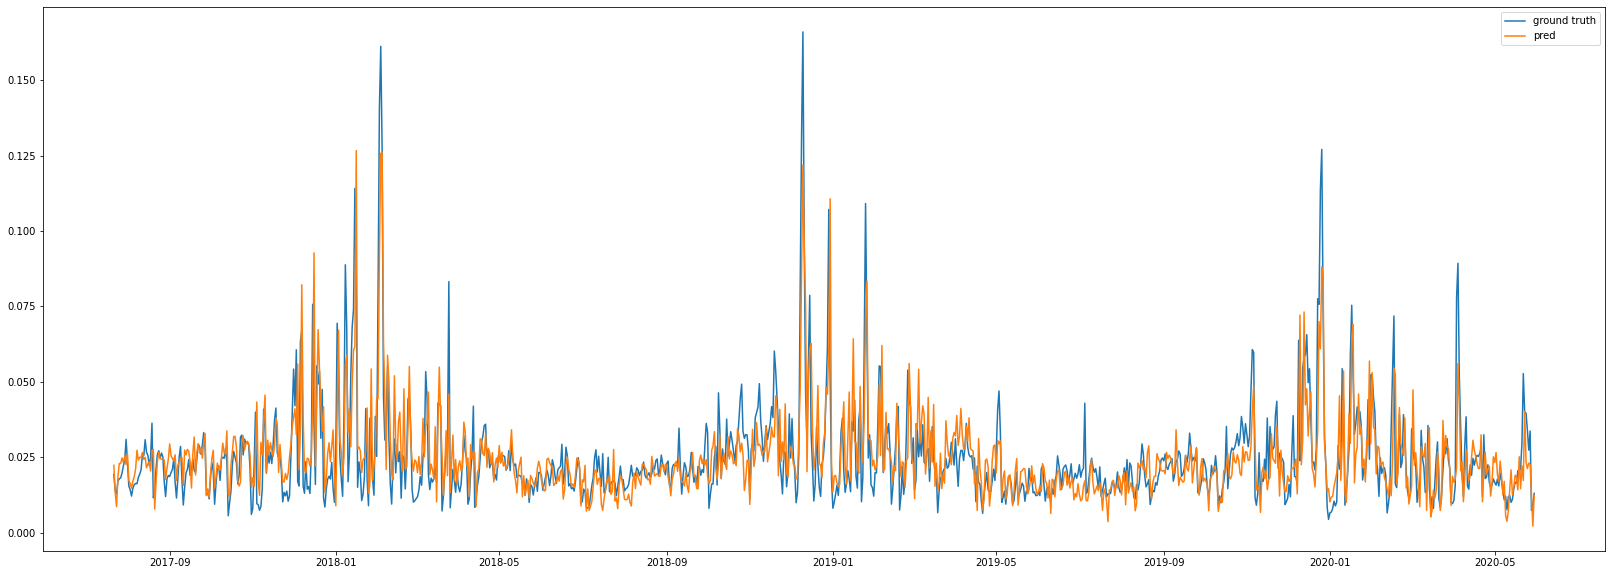

In [ ]:
model = load_model(logpath_ms)
df_avg = df.resample('D').mean()
gr_truth = get_targets_from_gen(test_generator)
gr_truth_avg = np.mean(gr_truth.reshape(-1, 24), axis=1)

y_pred = model.predict(test_generator)
y_pred_avg = np.mean(y_pred.reshape(-1, 24), axis=1)

fig = plt.figure(figsize=(28,10))
plt.plot(df_avg.index[-len(gr_truth_avg):], gr_truth_avg, label='ground truth')
plt.plot(df_avg.index[-len(y_pred):], y_pred_avg, label='pred')
# plt.plot(df_avg.index[-len(y_pred)-1:-1], y_pred_avg, label='pred day 1 after sliding window')
plt.legend()

Може да изчислим какъв е MSE (mean squared error) на прогнозата и да го сравним с наивния модел 'днес ще е като вчера':

In [ ]:
mse = round(sum((y_pred_avg.flatten() - gr_truth_avg)**2)/len(y_pred), 7)
print('mse =', mse)

# MSE of a naive baseline, if we just make the model predict a value at t1 that is equal to the value for the previous period t0
y_t0 = gr_truth_avg[:-1] #test_generator.targets[test_generator.start_index-1:test_generator.end_index,0]
y_t1 = gr_truth_avg[1:] #test_generator.targets[test_generator.start_index:test_generator.end_index + 1,0]
mse_naive = sum((y_t1-y_t0)**2)/len(y_t0)
print('mse_naive =', mse_naive)

# calculating MSE of the predictions shifted by 7 points into the past
# mse_delta_1_day = sum((y_pred_avg.flatten()[1:] - gr_truth_avg[:-1])**2)/len(y_pred[:-4])
# print('mse_delta_1_day =', mse_delta_1_day)

mse = 0.0001194
mse_naive = 0.00017790934922445


Този модел може да използва не само последните X часа за да предскаже какво ще стане в следващите Y часа, а може и да предскаже и след промеждутък време, да кажем други ден или следващата седмица. И точноста е също по-висoкa от наивно предположение

In [ ]:
# split the data into 80% training 10% validation, 10% testing
train_generator2 = TimeseriesGenerator(X[:(-n_input-1)], y[:(-n_input-1)], length=n_input, stride=72, batch_size=32, end_index=int(0.6*len(X[:(-n_input-1)])))
val_generator2 = TimeseriesGenerator(X[:(-n_input-1)], y[:(-n_input-1)], length=n_input, stride=72, batch_size=32, start_index=int(0.6*len(X[:(-n_input-1)])), end_index=int(0.8*len(X[:(-n_input-1)])))

# in line below I am looking for the correct start index for the generator. The start_index needs to be after the 90% of the data treshholds (my test data)
# and it needs to be a multiple of 24 (hours), because I wanto to start with an index corresponding to time  00.00 am
start_index = int(0.8*len(X[:(-n_input-1)])) + (24 - int(0.8*len(X[:(-n_input-1)])) % 24)
test_generator2 = TimeseriesGenerator(X[:(-n_input-1)], y[:(-n_input-1)], length=n_input, stride=72, batch_size=64, start_index=start_index)


K.clear_session()
modelsave_cb2 = tf.keras.callbacks.ModelCheckpoint('./bestmodel_stride=72_20210219_for_presentation.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

## model taken from here: https://www.tensorflow.org/tutorials/structured_data/time_series?fbclid=IwAR1CfmX6adoEpeVF9hqc1eNMf7AJIZM0pEzWpyMvbfFizxsa2uR97yDvgKQ#recurrent_neural_network
model2 = Sequential()
# model.add(LSTM(16, return_sequences=True, input_shape=(n_input, X.shape[1]))) #return_sequences=True, 
# model.add(Dropout(0.3))
## model.add(MaxPool1D(2))
model2.add(LSTM(32, return_sequences=False, input_shape=(n_input, X.shape[1])))
## model.add(MaxPool1D(3))
# model.add(Dense(24*X.shape[1]))
model2.add(Dense(24))
model2.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

model2.fit(train_generator2, validation_data=val_generator2, epochs=20, verbose=0,
            callbacks=[modelsave_cb2])


model2 = load_model('./bestmodel_stride=72_20210219_for_presentation.h5')
gr_truth2 = get_targets_from_gen(test_generator2)
gr_truth_avg2 = np.mean(gr_truth2.reshape(-1, 24), axis=1)

y_pred2 = model2.predict(test_generator2)
y_pred_avg2 = np.mean(y_pred2.reshape(-1, 24), axis=1)


Epoch 00001: val_loss improved from inf to 0.00386, saving model to ./bestmodel_stride=72_20210219_for_presentation.h5

Epoch 00002: val_loss improved from 0.00386 to 0.00327, saving model to ./bestmodel_stride=72_20210219_for_presentation.h5

Epoch 00003: val_loss improved from 0.00327 to 0.00275, saving model to ./bestmodel_stride=72_20210219_for_presentation.h5

Epoch 00004: val_loss improved from 0.00275 to 0.00254, saving model to ./bestmodel_stride=72_20210219_for_presentation.h5

Epoch 00005: val_loss improved from 0.00254 to 0.00233, saving model to ./bestmodel_stride=72_20210219_for_presentation.h5

Epoch 00006: val_loss did not improve from 0.00233

Epoch 00007: val_loss improved from 0.00233 to 0.00206, saving model to ./bestmodel_stride=72_20210219_for_presentation.h5

Epoch 00008: val_loss did not improve from 0.00206

Epoch 00009: val_loss improved from 0.00206 to 0.00194, saving model to ./bestmodel_stride=72_20210219_for_presentation.h5

Epoch 00010: val_loss improved 

In [ ]:
# calculating MSE of the predictions
mse2 = round(sum((y_pred_avg2.flatten() - gr_truth_avg2)**2)/len(y_pred2), 7)
print('mse, 72 h shift:', mse2)

# MSE of a naive baseline, if we just make the model predict a value at t1 that is equal to the value for the previous period t0
y2_t0 = gr_truth_avg2[:-3] #test_generator.targets[test_generator.start_index-1:test_generator.end_index,0]
y2_t1 = gr_truth_avg2[3:] #test_generator.targets[test_generator.start_index:test_generator.end_index + 1,0]
mse2_naive = sum((y2_t1-y2_t0)**2)/len(y2_t0)
print('mse of naive model, 72 h shift:', mse2_naive)

mse, 72 h shift: 0.0002072
mse of naive model, 72 h shift: 0.0005670806319942086


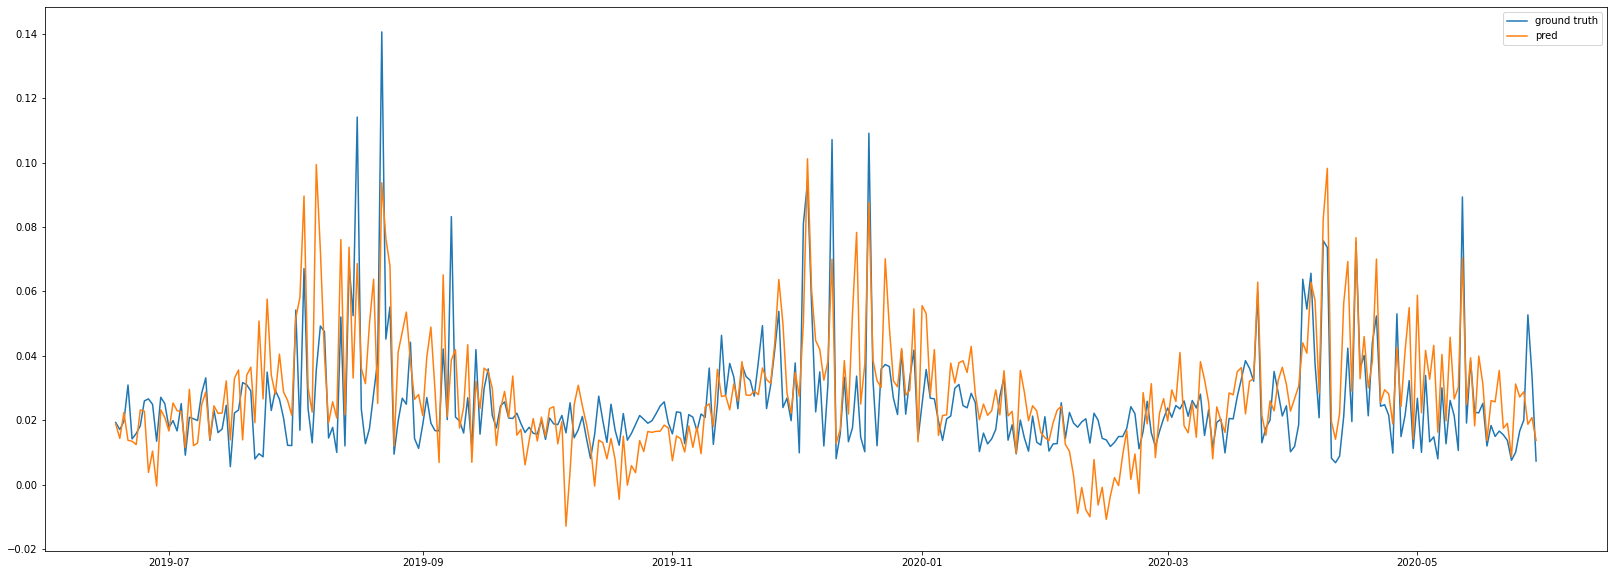

In [ ]:
fig = plt.figure(figsize=(28,10))
plt.plot(df_avg.index[-len(gr_truth_avg2):], gr_truth_avg2, label='ground truth')
plt.plot(df_avg.index[-len(y_pred2):], y_pred_avg2, label='pred')
# plt.plot(df_avg.index[-len(y_pred)-1:-1], y_pred_avg, label='pred day 1 after sliding window')
plt.legend()

##3. Как може да изглежда статията?
- най-вече да е сравнение с някакъв вид друг модел
- без суперлативни очаквания, нещо от сорта на "abilities and limitations of public ML libraries for PM10 predictions" или "the abilities of citizen science forecasts of PM10"
- мога да добавя като допълнителен модел още един статистически, по-конвенционален, от вида ARIMA


- Kakvo sa pravili drugite i kak moje da e prinos? Tryabvo mu literaturen obzor

### Коментари от Венци

- да проверя как ще изглежда като заменя точката на оросяване с "деф" (?): деф=Температура - (точка на оросяване). Мога да поискам данни за температурата от самото място, което измерва температурата. Трябва да е винаги >0
- ще се подобри ли прогнозата ако включа и time stamp за дневните часове
- да питам летището дали могат да ми дадат данни за валежи и други величини
- мога ли да набавя данни за тецовете?
- да направя прогноза която не предсказва самите стойности а дали има надвишения над нормите или не. колко точна ще бъде тази прогноза
- дава ли LSTM модела, подобно на ARIMA модела на facebook prophet, интервалите за сигма, 2*сигма и т.н.
- да потърся ревюта/обзори